In [1]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""
os.environ['ANTHROPIC_API_KEY'] = ""

In [2]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [3]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [4]:
from langgraph.prebuilt.chat_agent_executor import AgentRouterState
from langgraph.prebuilt import create_react_agent

In [5]:
model = ChatOpenAI(model="gpt-4o")

In [6]:
model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langgraph.prebuilt.handoff import create_handoff_tool, GraphCommandTool

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
from langchain_core.messages import HumanMessage

In [11]:
from typing import Callable

In [12]:
# output processors

def keep_last_message_as_human(state):
    updated_state = state.copy()
    last_message_content = updated_state["messages"][-1].content
    # TODO: how do we propagate agent name here?
    last_message = HumanMessage(content=last_message_content)
    updated_state["messages"] = [last_message]
    return updated_state

In [13]:
from langgraph.prebuilt.chat_agent_executor import make_agent_node, add_entrypoint_router

In [14]:
bob_tool = create_handoff_tool("bob", name="transfer_to_bob")
alice_tool = create_handoff_tool("alice", name="transfer_to_alice")
charlie_tool = create_handoff_tool("charlie", name="transfer_to_charlie")

In [15]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool], state_modifier="You're Bob.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [16]:
from IPython.display import display, Image

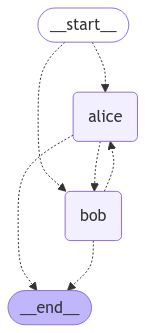

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable": {"thread_id": "1"}}

In [21]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='fcac6c21-dfd7-416e-9f9d-2a476c9a64d0')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content='Welcome! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='16fd4c80-cf4d-4f90-bd77-38736a38fe5d')], 'node': 'bob'}}




In [22]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="You're speaking to Bob! How can I assist you today?", additional_kwargs={}, response_metadata={}, id='6452f635-6132-4e37-ae83-2236386a0f24')], 'node': 'bob'}}




In [23]:
for chunk in graph.stream({"messages": [("user", "what's your name?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content='My name is Bob. How can I help you today?', additional_kwargs={}, response_metadata={}, id='7e1ecea9-fd8e-4417-b21a-ce0cc410ebc1')], 'node': 'bob'}}




In [24]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('bob:c4a72001-25dd-8443-c966-8c24c18310a4',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EfLL5Sy5zZktEOMwPEFgSrz6', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 162, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-92181704-f67b-490b-9031-fcba3dbaae71-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_EfLL5Sy5zZktEOMwPEFgSrz6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 17, 'total_tokens': 179, 'input_token_details': {'audio': 0, 'cache_r

In [25]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="Transferred to 'alice'!", additional_kwargs={}, response_metadata={}, id='aa11ecdd-fafe-411f-98b8-dddfa7735f17')], 'node': 'alice'}}


{'alice': {'messages': [HumanMessage(content='Hi! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='bd70f40e-3938-4d5b-99f6-5cf1ca8dc21c')], 'node': 'alice'}}




In [26]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:cc44000d-88fd-c6e5-ed5b-d45d57695bdd',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_au8sBrvIzrUKTij5m4RCzUXD', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 225, 'total_tokens': 242, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_467dc6e35f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-52b315a2-b6a9-41c4-b17b-106d108e9e10-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_au8sBrvIzrUKTij5m4RCzUXD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 225, 'output_tokens': 17, 'total_tokens': 242, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

---

In [31]:
builder = StateGraph(AgentRouterState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice the cat.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool, charlie_tool], state_modifier="You're Bob the dog.", output_processor=keep_last_message_as_human)
charlie = make_agent_node(model, [bob_tool], state_modifier="You're Charlie the parrot.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob), ("charlie", bob)], default_start_node="alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

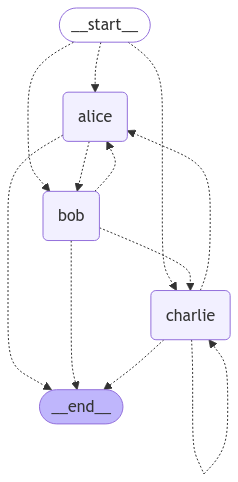

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='1561b5a8-a1c6-4791-881c-12b93b89c1e5')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content='Woof! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='21835c26-c0ea-4b6d-9c02-0dc3cdc3112a')], 'node': 'bob'}}




In [34]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="Transferred to 'charlie'!", additional_kwargs={}, response_metadata={}, id='39c6fefc-8f3f-42d0-9a46-59d1cd3a689c')], 'node': 'charlie'}}


{'charlie': {'messages': [HumanMessage(content="Transferred to 'charlie'!", additional_kwargs={}, response_metadata={}, id='92a72c78-add3-45db-b65e-570973dfae7f')], 'node': 'charlie'}}


{'charlie': {'messages': [HumanMessage(content='Woof! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='368e301e-4023-4c7d-8344-eb76089bad9b')], 'node': 'charlie'}}




In [35]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'charlie': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='a9143fab-a367-40b3-9e21-027f52f48943')], 'node': 'charlie'}}




---

### Supervisor

In [38]:
builder = StateGraph(AgentRouterState)

supervisor_tool = create_handoff_tool("supervisor", name="transfer_to_supervisor")

supervisor = make_agent_node(model_anthropic, [alice_tool, bob_tool], state_modifier=(
    "You're team supervisor managing Alice and Bob. "
    "Alice is an expert at multiplication, Bob is great at addition. "
    "To answer user question, transfer to one of them that has the requisite skills. "
    "Once you have the final answer to user question, do not transfer -- respond to user directly!"
))
bob = make_agent_node(model_anthropic, [add, supervisor_tool], state_modifier="You're Bob. Once you're done adding, you MUST call supervisor.")
alice = make_agent_node(model_anthropic, [multiply, supervisor_tool], state_modifier="You're Alice. Once you're done multiplying, you MUST call supervisor.")

add_entrypoint_router(builder, route_to=[("supervisor", supervisor), ("alice", alice), ("bob", bob)], default_start_node="supervisor")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

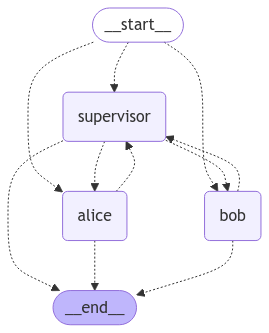

In [39]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('supervisor:0b0c4234-4803-7b9f-47e6-3dbb84127a48',), {'agent': {'messages': [AIMessage(content=[{'text': "Since this is an addition problem, I'll transfer to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_01B2Pj3HXoUSfYwT1tZuw59q', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01VohUmQTGJbzt7nFji7gFiA', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 481, 'output_tokens': 57}}, id='run-e6d2f1dd-9d24-415d-a6bc-d95b3a278732-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01B2Pj3HXoUSfYwT1tZuw59q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 481, 'output_tokens': 57, 'total_tokens': 538, 'input_token_details': {}})]}})


(('supervisor:0b0c4234-4803-7b9f-47e6-3dbb84127a48',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='7e5e6235-5eea-4170-9b4d-2e503d03e1

In [41]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 391 + 193", additional_kwargs={}, response_metadata={}, id='d5123131-38cf-4337-98f1-6379b6018bef'),
 AIMessage(content=[{'text': "Since this is an addition problem, I'll transfer to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_01B2Pj3HXoUSfYwT1tZuw59q', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01VohUmQTGJbzt7nFji7gFiA', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 481, 'output_tokens': 57}}, id='run-e6d2f1dd-9d24-415d-a6bc-d95b3a278732-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01B2Pj3HXoUSfYwT1tZuw59q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 481, 'output_tokens': 57, 'total_tokens': 538, 'input_token_details': {}}),
 ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='7e5e6235-5eea-4170-9b4d-2e503d03e169', tool_call_id='toolu_01B2Pj

In [42]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='I have the answer for you: 391 + 193 = 584. Is there anything else I can help you with?', additional_kwargs={}, response_metadata={'id': 'msg_01Cp4JqZnQfcCQj3HRzsLZLE', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 741, 'output_tokens': 32}}, id='run-2284e002-dc2f-4f3c-8df4-3bad17c3609c-0', usage_metadata={'input_tokens': 741, 'output_tokens': 32, 'total_tokens': 773, 'input_token_details': {}})

---

### Network

In [43]:
alice = make_agent_node(model_anthropic, [multiply, bob_tool], state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition.")
bob = make_agent_node(model_anthropic, [add, alice_tool], state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication.")

builder = StateGraph(AgentRouterState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
for chunk in graph.stream({"messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:b8fc0d5d-4aa9-c9a4-ee49-b43d1aa3a8fc',), {'agent': {'messages': [AIMessage(content=[{'text': "I apologize, but as Alice the multiplication expert, I can't directly help with addition. However, I can transfer this question to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_01LwnG8jZh9WjqWErLpiA4Wy', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RJBJvSnnG6ZPN1XEghggZL', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 73}}, id='run-5f5847ae-6365-444e-9662-a2bf94ba8b6a-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01LwnG8jZh9WjqWErLpiA4Wy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 73, 'total_tokens': 530, 'input_token_details': {}})]}})
(('alice:b8fc0d5d-4aa9-c9a4-ee49-b43d1aa3a8fc',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob

In [46]:
for chunk in graph.stream({"messages": [("user", "now multiply that by 11")]}, config, subgraphs=True):
    print(chunk)

(('bob:50810f00-fd81-15c3-5019-377a5f887bb1',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm Bob the addition expert, I'm not able to help with multiplication. Let me transfer this to Alice who specializes in multiplication.", 'type': 'text'}, {'id': 'toolu_01RWvNP7tjG192kWyeyMjjEK', 'input': {}, 'name': 'transfer_to_alice', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01HD7w4JG6Fx7vGqz2mkew81', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 686, 'output_tokens': 68}}, id='run-a08b537e-0a9a-4405-90fc-b502a4d343e4-0', tool_calls=[{'name': 'transfer_to_alice', 'args': {}, 'id': 'toolu_01RWvNP7tjG192kWyeyMjjEK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 686, 'output_tokens': 68, 'total_tokens': 754, 'input_token_details': {}})]}})
(('bob:50810f00-fd81-15c3-5019-377a5f887bb1',), {'tools': {'messages': [ToolMessage(content="Transferred to 'alice'!", name='transfer_

In [48]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='5 multiplied by 11 equals 55.', additional_kwargs={}, response_metadata={'id': 'msg_016MBfH9KgTUPLFihkk2yKnp', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 874, 'output_tokens': 16}}, id='run-fd1ac76f-4802-4ad9-8d52-2e64e8311705-0', usage_metadata={'input_tokens': 874, 'output_tokens': 16, 'total_tokens': 890, 'input_token_details': {}})

---

### Different state schema in parent vs child state

In [49]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

In [50]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [51]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    updated_state = keep_last_message_as_human(state)
    return {**updated_state, "parent_messages": updated_state["messages"]}

In [56]:
alice = make_agent_node(
    model_anthropic,
    [multiply, bob_tool],
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition."
)
bob = make_agent_node(
    model_anthropic,
    [add, alice_tool],
    input_processor=input_processor,
    output_processor=output_processor,
    state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication."
)

builder = StateGraph(CustomParentState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [57]:
config = {"configurable": {"thread_id": "1"}}

In [58]:
for chunk in graph.stream({"parent_messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:ae8236de-3d52-4229-190d-e02c007a30fe',), {'agent': {'messages': [AIMessage(content=[{'text': "I apologize, but as Alice the multiplication expert, I actually can't perform addition myself. However, I can ask Bob who is good at addition! Let me transfer to Bob who can help you with this calculation.", 'type': 'text'}, {'id': 'toolu_015NwdJXBeiDTGPcKVBdH2iL', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01GUUL54HvtyDo63cU5QWr5E', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 83}}, id='run-7f67061a-e7d5-4c33-bd2b-b0f639911d99-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_015NwdJXBeiDTGPcKVBdH2iL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 83, 'total_tokens': 540, 'input_token_details': {}})]}})
(('alice:ae8236de-3d52-4229-190d-e02c007a30fe',), {'tools': {'messages':

In [59]:
graph.get_state(config).values.keys()

dict_keys(['parent_messages', 'node'])

In [60]:
graph.get_state(config).values["parent_messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='1dca771b-970d-4752-b11e-e2a7ace155b0'),
 HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='8c29d116-9d1c-4d2f-a914-8d6503cab128'),
 HumanMessage(content="The result is 5! If you need any help with multiplication, I can transfer you to Alice who's an expert in that area.", additional_kwargs={}, response_metadata={}, id='cae1da2c-e7f0-43da-aad7-6bb920922c6d')]

### Tools that update state (externally)

In [61]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

    # this key is not available to the child graph
    user_name: str

In [62]:
from langchain_core.tools import tool

In [63]:
@tool(response_format="content_and_artifact", return_direct=True)
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [64]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state)
    return {**state, "parent_messages": state["messages"]}

In [65]:
alice = make_agent_node(
    model,
    [get_user_name],
    input_processor=input_processor,
    output_processor=output_processor,
)

builder = StateGraph(CustomParentState)
builder.add_node("alice", alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [66]:
config = {"configurable": {"thread_id": "1"}}

In [67]:
for chunk in graph.stream({"parent_messages": [("user", "get user name")]}, config):
    print(chunk)

{'alice': {'parent_messages': [HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='12b094ab-47bb-4612-9391-d94d1f5a6b5c')], 'user_name': 'Meow'}}


In [68]:
graph.get_state(config).values

{'parent_messages': [HumanMessage(content='get user name', additional_kwargs={}, response_metadata={}, id='200f8c62-6bcf-4d57-9d0b-a855406d0cd7'),
  HumanMessage(content='Successfully retrieved user name', additional_kwargs={}, response_metadata={}, id='12b094ab-47bb-4612-9391-d94d1f5a6b5c')],
 'user_name': 'Meow'}

### Tools that update state (internally)

In [69]:
class CustomParentState(TypedDict):
    # deliberately use a different key here
    parent_messages: Annotated[list[BaseMessage], add_messages]
    node: str

In [70]:
class CustomChildState(AgentRouterState):
    user_name: str

In [71]:
from langchain_core.tools import tool

In [72]:
@tool(response_format="content_and_artifact")
def get_user_name():
    """Retrieve user name"""
    return "Successfully retrieved user name", GraphCommand(update={"user_name": "Meow"})

In [73]:
def input_processor(state):
    return {**state, "messages": state["parent_messages"]}

def output_processor(state):
    state = keep_last_message_as_human(state)
    return {**state, "parent_messages": state["messages"]}

In [74]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [75]:
alice = make_agent_node(
    model,
    [get_user_name, add],
    input_processor=input_processor,
    output_processor=output_processor,
    state_schema=CustomChildState,
    state_modifier=state_modifier
)

builder = StateGraph(CustomParentState)
builder.add_node("alice", alice)
builder.add_edge(START, "alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [76]:
config = {"configurable": {"thread_id": "1"}}

In [77]:
graph.invoke({"parent_messages": [("user", "look up my name, add 2 + 3 and respond to me by name")]}, config)

{'parent_messages': [HumanMessage(content='look up my name, add 2 + 3 and respond to me by name', additional_kwargs={}, response_metadata={}, id='9d10f4fe-d2e1-498e-b85e-3f4fcf851348'),
  HumanMessage(content='Hello Meow! The sum of 2 and 3 is 5.', additional_kwargs={}, response_metadata={}, id='c3c27a19-9662-4f78-9bba-c912f42a8944')]}

---

### Test interrupts from inside tools

TL;DR works w/ a single graph, doesn't work w/ subgraphs

In [79]:
from langgraph.types import interrupt, Command

In [80]:
@tool(response_format="content_and_artifact")  #, return_direct=True)
def get_user_name():
    """Retrieve user name"""
    user_name = interrupt("Please provider user name")
    return "Successfully retrieved user name", GraphCommand(update={"user_name": user_name})

In [81]:
def state_modifier(state):
    user_name = state.get("user_name")
    if user_name is None:
        return state["messages"]

    system_msg = f"User name is {user_name}"
    return [{"role": "system", "content": system_msg}] + state["messages"]

In [89]:
test_agent = make_agent_node(model, [get_user_name], state_schema=CustomState, state_modifier=state_modifier)

builder = StateGraph(CustomState)
builder.add_node("agent", test_agent)
builder.add_edge(START, "agent")
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [90]:
# checkpointer = MemorySaver()
# test_agent = create_react_agent(model, [get_user_name], checkpointer=checkpointer)

In [92]:
graph.invoke({"messages": [("user", "hi -- please get the user name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='5b4f9de3-13d3-4d1e-963d-e1b8b80dea96')]}

In [94]:
graph.get_state(config).tasks

(PregelTask(id='54922a05-cd7e-3094-ebe0-e55eb21bf24e', name='agent', path=('__pregel_pull', 'agent'), error=None, interrupts=(Interrupt(value='Please provider user name', resumable=True, ns=['agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e', 'tools:d70d2003-c7b7-06fe-faf1-0ee3731a77f2'], when='during'),), state={'configurable': {'thread_id': '1', 'checkpoint_ns': 'agent:54922a05-cd7e-3094-ebe0-e55eb21bf24e'}}, result=None),)

In [96]:
# graph.invoke(Command(resume="Archibald"), config)

In [88]:
test_agent.invoke({"messages": [("user", "whats my name")]}, config)

{'messages': [HumanMessage(content='hi -- please get the user name', additional_kwargs={}, response_metadata={}, id='3662d0e1-7f5b-4a39-b8fb-d114d69c5138'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'function': {'arguments': '{}', 'name': 'get_user_name'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 43, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_62f96df568', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d5cf2ceb-5417-4c57-9955-059cd1d84c9e-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'call_KJah0Kamn5i3Gk8v8qaBukCR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 11

---